https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

In [3]:
from loguru import logger
import sys

# only if you want it shorter
logger.remove()
logger.add(sys.stderr, format="<level>{message}</level>", level="WARNING")

1

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [5]:
plt.style.use('seaborn-v0_8')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Was asked to gather along dimension 0.*")
warnings.filterwarnings("ignore", ".*There is an imbalance between your GPUs.*")

In [6]:
max_chars = 2000


In [7]:

# https://huggingface.co/collections/unsloth/llama-32-66f46afde4ca573864321a22
model_name = "unsloth/Llama-3.2-1B"
model_name = "unsloth/Llama-3.2-1B-bnb-4bit"
# Model Release Date: Sept 25, 2024
# launch date 9/25/2024 https://github.com/meta-llama/llama-models/blob/main/README.md
# https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing
# unsloth/Llama-3.2-3B
# Data Freshness: The pretraining data has a cutoff of December 2023.

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [8]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [9]:
def reset_model(base_model):
    # peft_config = LoraConfig(
    #     # task_type=TaskType.TOKEN_CLS, 
    #     target_modules=[ "fc2",  "Wqkv",],
    #     inference_mode=False, r=4, lora_alpha=4, 
    #     # lora_dropout=0.1, 
    #     # bias="all"
    # )
    # peft_config = IA3Config(
    #     target_modules=[ "fc2",  "Wqkv",], 
    #         feedforward_modules=["fc2"],
    #         inference_mode=False,
    # )
    peft_config = IA3Config(
        # target_modules=[ "fc2",  "Wqkv", 'out_proj', 'fc1'], 
        #     feedforward_modules=["fc2", 'fc1', 'out_proj'],
        #     inference_mode=False,
    )
    random_name = "peft_" + str(np.random.randint(0, 100000))
    model = get_peft_model(base_model, peft_config, adapter_name=random_name)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [10]:
from bs_writing_detector.data.load_md import load_md_df
from bs_writing_detector.metrics.ppx import perplexity_compute_ds
from pathlib import Path
df = load_md_df(Path("../samples/"))

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset

## Lightning helpers

In [12]:
def eval(model, tokenizer, ds_val: Dataset):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute_ds(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')['nlls'][0]
        results2 = perplexity_compute_ds(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')['nlls'][0]
    return dict(before=results, after=results2)


# Train

In [13]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [14]:
from sklearn.model_selection import train_test_split

def tokenize_and_split(examples):
    l = len(tokenizer(examples).input_ids[0])
    max_len = min(l//3, max_chars) # break into at least 5
    max_len = max(max_len, 10)


    result = tokenizer(
        examples,
        add_special_tokens=False,
        truncation=True,
        stride=2, # – If set to a number along with max_length, the overflowing tokens returned will contain some tokens from the main sequence returned. The value of this argument defines the number of additional tokens.
        max_length=max_len,
        return_overflowing_tokens=True,
        return_attention_mask=True,
    )
    return result

sample = df.sample(1).iloc[0]
s = sample['content']
d = Dataset.from_dict(tokenize_and_split([s]))
d2  = d.train_test_split(test_size=0.5, seed=42)
ds_train = d2['train']
ds_val = d2['test']
ds_val

Dataset({
    features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
    num_rows: 2
})

In [15]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 1
    verbose = False

    s = sample['content']

    d = Dataset.from_dict(tokenize_and_split([s]))
    d2  = d.train_test_split(test_size=0.5, seed=42)
    ds_train = d2['train']
    ds_val = d2['test']

    print(model.peft_config)
    model = reset_model(base_model)

    # verify that we have reset it
    print(model.peft_config)


    # eval(model, tokenizer, ds_train)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            # gradient_accumulation_steps=1,
            # warmup_steps=6,
            warmup_ratio=0.1,
            # max_steps=50,
            num_train_epochs=3,
            learning_rate=1e-3,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, ds_train).items()}
    result = eval(model, tokenizer, ds_val)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


In [42]:
data[0].keys()

dict_keys(['before', 'after', 'hist', 'train/before', 'train/after', 'title', 'f', 'content', 'url', 'novelty', 'date', 'in_training'])

In [18]:
data = []
for i in tqdm(range(len(df))):
    sample = df.iloc[i]
    r = learn_sample(sample)
    print(sample['title'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

  0%|          | 0/30 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.8911, 'grad_norm': 0.8076428174972534, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.3384, 'grad_norm': 0.6929064989089966, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.5387918949127197, 'eval_runtime': 0.1312, 'eval_samples_per_second': 15.24, 'eval_steps_per_second': 7.62, 'epoch': 1.0}
{'loss': 2.7436, 'grad_norm': 0.7699084281921387, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.1441, 'grad_norm': 0.6051006317138672, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.5293452739715576, 'eval_runtime': 0.1328, 'eval_samples_per_second': 15.055, 'eval_steps_per_second': 7.528, 'epoch': 2.0}
{'loss': 2.5154, 'grad_norm': 0.749704122543335, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.0386, 'grad_norm': 0.5838078856468201, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.5258588790893555, 'eval_runtime': 0.1318, 'eval_samples_per_second': 15.171, 'eval_steps_per_second': 7.585, 'epoch': 3.0}
{'train_runtime': 1.3375, 'train_samples_per_second': 4.

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.2976, 'grad_norm': 1.1653801202774048, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.499, 'grad_norm': 1.3143912553787231, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.3701250553131104, 'eval_runtime': 0.1588, 'eval_samples_per_second': 12.593, 'eval_steps_per_second': 6.297, 'epoch': 1.0}
{'loss': 3.0943, 'grad_norm': 1.04639732837677, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 3.1374, 'grad_norm': 1.0442923307418823, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.351206064224243, 'eval_runtime': 0.127, 'eval_samples_per_second': 15.745, 'eval_steps_per_second': 7.872, 'epoch': 2.0}
{'loss': 2.7867, 'grad_norm': 0.9014344811439514, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.9493, 'grad_norm': 0.9459804892539978, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.344069242477417, 'eval_runtime': 0.1281, 'eval_samples_per_second': 15.616, 'eval_steps_per_second': 7.808, 'epoch': 3.0}
{'train_runtime': 1.3909, 'train_samples_per_second': 4.314

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.3063, 'grad_norm': 1.185476303100586, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.3628, 'grad_norm': 1.5031108856201172, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.6609110832214355, 'eval_runtime': 0.1593, 'eval_samples_per_second': 12.556, 'eval_steps_per_second': 6.278, 'epoch': 1.0}
{'loss': 3.0717, 'grad_norm': 0.9321146011352539, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 3.0218, 'grad_norm': 1.1784974336624146, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.6481850147247314, 'eval_runtime': 0.1593, 'eval_samples_per_second': 12.552, 'eval_steps_per_second': 6.276, 'epoch': 2.0}
{'loss': 2.7501, 'grad_norm': 0.7790453433990479, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.8441, 'grad_norm': 1.0859301090240479, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.6467812061309814, 'eval_runtime': 0.1589, 'eval_samples_per_second': 12.588, 'eval_steps_per_second': 6.294, 'epoch': 3.0}
{'train_runtime': 1.6521, 'train_samples_per_second': 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 4.1433, 'grad_norm': 1.3135420083999634, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.8979, 'grad_norm': 1.6989140510559082, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.8832738399505615, 'eval_runtime': 0.1567, 'eval_samples_per_second': 12.767, 'eval_steps_per_second': 6.384, 'epoch': 1.0}
{'loss': 3.8552, 'grad_norm': 1.1130166053771973, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 3.445, 'grad_norm': 1.2440484762191772, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.857309103012085, 'eval_runtime': 0.1665, 'eval_samples_per_second': 12.015, 'eval_steps_per_second': 6.007, 'epoch': 2.0}
{'loss': 3.437, 'grad_norm': 1.004622459411621, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 3.2143, 'grad_norm': 1.0474002361297607, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.846127986907959, 'eval_runtime': 0.1571, 'eval_samples_per_second': 12.729, 'eval_steps_per_second': 6.365, 'epoch': 3.0}
{'train_runtime': 2.0371, 'train_samples_per_second': 2.94

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.5963, 'grad_norm': 1.7606483697891235, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.8611, 'grad_norm': nan, 'learning_rate': 0.001, 'epoch': 1.0}
{'eval_loss': 4.20759391784668, 'eval_runtime': 0.1417, 'eval_samples_per_second': 14.112, 'eval_steps_per_second': 7.056, 'epoch': 1.0}
{'loss': 3.5963, 'grad_norm': 1.7607665061950684, 'learning_rate': 0.0008, 'epoch': 1.5}
{'loss': 3.8058, 'grad_norm': 5.883133411407471, 'learning_rate': 0.0006, 'epoch': 2.0}
{'eval_loss': 4.105123519897461, 'eval_runtime': 0.1429, 'eval_samples_per_second': 13.994, 'eval_steps_per_second': 6.997, 'epoch': 2.0}
{'loss': 2.6548, 'grad_norm': 1.1668059825897217, 'learning_rate': 0.0004, 'epoch': 2.5}
{'loss': 3.4369, 'grad_norm': 1.433318853378296, 'learning_rate': 0.0002, 'epoch': 3.0}
{'eval_loss': 4.070194721221924, 'eval_runtime': 0.1445, 'eval_samples_per_second': 13.837, 'eval_steps_per_second': 6.918, 'epoch': 3.0}
{'train_runtime': 2.0652, 'train_samples_per_second': 2.905, 'train_step

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.8892, 'grad_norm': 1.9384897947311401, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.5209, 'grad_norm': 1.7461295127868652, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.852980613708496, 'eval_runtime': 0.1324, 'eval_samples_per_second': 15.108, 'eval_steps_per_second': 7.554, 'epoch': 1.0}
{'loss': 2.5119, 'grad_norm': 1.536733865737915, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 1.8856, 'grad_norm': 1.3685024976730347, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.8215484619140625, 'eval_runtime': 0.1313, 'eval_samples_per_second': 15.234, 'eval_steps_per_second': 7.617, 'epoch': 2.0}
{'loss': 2.0365, 'grad_norm': 1.2905688285827637, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.6189, 'grad_norm': 1.1336886882781982, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.816497802734375, 'eval_runtime': 0.143, 'eval_samples_per_second': 13.982, 'eval_steps_per_second': 6.991, 'epoch': 3.0}
{'train_runtime': 1.9967, 'train_samples_per_second': 3.0

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.8982, 'grad_norm': 1.66070556640625, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 4.0169, 'grad_norm': 1.7133033275604248, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 4.369366645812988, 'eval_runtime': 0.1559, 'eval_samples_per_second': 12.828, 'eval_steps_per_second': 6.414, 'epoch': 1.0}
{'loss': 3.5287, 'grad_norm': 1.2428947687149048, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 3.3378, 'grad_norm': 1.4541748762130737, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 4.356468677520752, 'eval_runtime': 0.158, 'eval_samples_per_second': 12.661, 'eval_steps_per_second': 6.33, 'epoch': 2.0}
{'loss': 3.0659, 'grad_norm': 0.93393474817276, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 3.0109, 'grad_norm': 1.3038973808288574, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 4.354191780090332, 'eval_runtime': 0.1594, 'eval_samples_per_second': 12.548, 'eval_steps_per_second': 6.274, 'epoch': 3.0}
{'train_runtime': 2.2731, 'train_samples_per_second': 2.64, 't

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.0168, 'grad_norm': 1.5045863389968872, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 1.9515, 'grad_norm': 1.6995381116867065, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.9758172035217285, 'eval_runtime': 0.1776, 'eval_samples_per_second': 11.263, 'eval_steps_per_second': 5.631, 'epoch': 1.0}
{'loss': 1.7056, 'grad_norm': 1.089555263519287, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 1.4582, 'grad_norm': 1.0138260126113892, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.888021469116211, 'eval_runtime': 0.1766, 'eval_samples_per_second': 11.327, 'eval_steps_per_second': 5.664, 'epoch': 2.0}
{'loss': 1.3538, 'grad_norm': 1.3632088899612427, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.2299, 'grad_norm': 0.939950168132782, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.8587775230407715, 'eval_runtime': 0.178, 'eval_samples_per_second': 11.236, 'eval_steps_per_second': 5.618, 'epoch': 3.0}
{'train_runtime': 2.458, 'train_samples_per_second': 2.44

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.9858, 'grad_norm': 2.995089054107666, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.6439, 'grad_norm': 1.58451247215271, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.429967164993286, 'eval_runtime': 0.1566, 'eval_samples_per_second': 12.768, 'eval_steps_per_second': 6.384, 'epoch': 1.0}
{'loss': 2.4293, 'grad_norm': 1.9177875518798828, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.992, 'grad_norm': 1.236825704574585, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.331143379211426, 'eval_runtime': 0.1591, 'eval_samples_per_second': 12.574, 'eval_steps_per_second': 6.287, 'epoch': 2.0}
{'loss': 1.8766, 'grad_norm': 1.3951705694198608, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.6741, 'grad_norm': 1.2922844886779785, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.304795742034912, 'eval_runtime': 0.1609, 'eval_samples_per_second': 12.431, 'eval_steps_per_second': 6.216, 'epoch': 3.0}
{'train_runtime': 2.2869, 'train_samples_per_second': 2.624, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.8747, 'grad_norm': 2.096508502960205, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.5899, 'grad_norm': 2.015336751937866, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.5862479209899902, 'eval_runtime': 0.1495, 'eval_samples_per_second': 13.375, 'eval_steps_per_second': 6.687, 'epoch': 1.0}
{'loss': 2.4316, 'grad_norm': 1.262579321861267, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.7612, 'grad_norm': 1.335434079170227, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.575761556625366, 'eval_runtime': 0.1538, 'eval_samples_per_second': 13.007, 'eval_steps_per_second': 6.503, 'epoch': 2.0}
{'loss': 1.8673, 'grad_norm': 1.1828184127807617, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.3797, 'grad_norm': 1.230667233467102, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.5691187381744385, 'eval_runtime': 0.1585, 'eval_samples_per_second': 12.622, 'eval_steps_per_second': 6.311, 'epoch': 3.0}
{'train_runtime': 2.656, 'train_samples_per_second': 2.259,

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.7673, 'grad_norm': 2.271059036254883, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.6765, 'grad_norm': 1.7324353456497192, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.623122215270996, 'eval_runtime': 0.1843, 'eval_samples_per_second': 10.85, 'eval_steps_per_second': 5.425, 'epoch': 1.0}
{'loss': 3.4631, 'grad_norm': 2.2982003688812256, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.3217, 'grad_norm': 1.8474977016448975, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.6200013160705566, 'eval_runtime': 0.186, 'eval_samples_per_second': 10.755, 'eval_steps_per_second': 5.378, 'epoch': 2.0}
{'loss': 2.9655, 'grad_norm': 1.1774643659591675, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.1688, 'grad_norm': 0.7183546423912048, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.624293565750122, 'eval_runtime': 0.1877, 'eval_samples_per_second': 10.657, 'eval_steps_per_second': 5.328, 'epoch': 3.0}
{'train_runtime': 2.6891, 'train_samples_per_second': 2.23

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.4617, 'grad_norm': 2.314183235168457, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.6791, 'grad_norm': 4.621912956237793, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.6804332733154297, 'eval_runtime': 0.1894, 'eval_samples_per_second': 10.557, 'eval_steps_per_second': 5.279, 'epoch': 1.0}
{'loss': 1.937, 'grad_norm': 1.5637528896331787, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.8931, 'grad_norm': 3.296773672103882, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.6785223484039307, 'eval_runtime': 0.1935, 'eval_samples_per_second': 10.335, 'eval_steps_per_second': 5.167, 'epoch': 2.0}
{'loss': 1.4123, 'grad_norm': 1.2823187112808228, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.5411, 'grad_norm': 1.8647823333740234, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.6879079341888428, 'eval_runtime': 0.1877, 'eval_samples_per_second': 10.653, 'eval_steps_per_second': 5.327, 'epoch': 3.0}
{'train_runtime': 2.7828, 'train_samples_per_second': 2.1

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.4176, 'grad_norm': 2.2762768268585205, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.2375, 'grad_norm': 2.3001043796539307, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.4287538528442383, 'eval_runtime': 0.1674, 'eval_samples_per_second': 11.949, 'eval_steps_per_second': 5.975, 'epoch': 1.0}
{'loss': 2.8886, 'grad_norm': 1.398822546005249, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.4307, 'grad_norm': 1.3295927047729492, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.4019901752471924, 'eval_runtime': 0.169, 'eval_samples_per_second': 11.832, 'eval_steps_per_second': 5.916, 'epoch': 2.0}
{'loss': 2.3348, 'grad_norm': 1.320399284362793, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.0626, 'grad_norm': 1.3593965768814087, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.4008889198303223, 'eval_runtime': 0.1679, 'eval_samples_per_second': 11.912, 'eval_steps_per_second': 5.956, 'epoch': 3.0}
{'train_runtime': 2.8613, 'train_samples_per_second': 2.

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.5776, 'grad_norm': 4.010377883911133, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.6589, 'grad_norm': 3.6633472442626953, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.2440617084503174, 'eval_runtime': 0.1115, 'eval_samples_per_second': 17.937, 'eval_steps_per_second': 8.968, 'epoch': 1.0}
{'loss': 2.9709, 'grad_norm': 2.407945394515991, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.4008, 'grad_norm': 2.5443220138549805, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.1872379779815674, 'eval_runtime': 0.1116, 'eval_samples_per_second': 17.928, 'eval_steps_per_second': 8.964, 'epoch': 2.0}
{'loss': 2.2253, 'grad_norm': 1.7101964950561523, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.8499, 'grad_norm': 1.7173982858657837, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.1816787719726562, 'eval_runtime': 0.1135, 'eval_samples_per_second': 17.622, 'eval_steps_per_second': 8.811, 'epoch': 3.0}
{'train_runtime': 2.6239, 'train_samples_per_second': 2

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.8964, 'grad_norm': 2.3559041023254395, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.8855, 'grad_norm': 2.407257556915283, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.4159514904022217, 'eval_runtime': 0.1467, 'eval_samples_per_second': 13.638, 'eval_steps_per_second': 6.819, 'epoch': 1.0}
{'loss': 2.2417, 'grad_norm': 1.521421194076538, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.004, 'grad_norm': 1.6388133764266968, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.386564254760742, 'eval_runtime': 0.1444, 'eval_samples_per_second': 13.846, 'eval_steps_per_second': 6.923, 'epoch': 2.0}
{'loss': 1.5761, 'grad_norm': 1.3388304710388184, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.6097, 'grad_norm': 1.3109463453292847, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.395535469055176, 'eval_runtime': 0.1498, 'eval_samples_per_second': 13.355, 'eval_steps_per_second': 6.677, 'epoch': 3.0}
{'train_runtime': 2.7717, 'train_samples_per_second': 2.16

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 4.6645, 'grad_norm': 2.517502546310425, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.5351, 'grad_norm': 1.9744876623153687, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 4.003051280975342, 'eval_runtime': 0.1857, 'eval_samples_per_second': 10.768, 'eval_steps_per_second': 5.384, 'epoch': 1.0}
{'loss': 4.0242, 'grad_norm': 1.5720769166946411, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.7426, 'grad_norm': 1.93308687210083, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.8951995372772217, 'eval_runtime': 0.1857, 'eval_samples_per_second': 10.772, 'eval_steps_per_second': 5.386, 'epoch': 2.0}
{'loss': 3.2325, 'grad_norm': 1.8237318992614746, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.3779, 'grad_norm': 1.5025017261505127, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.867494821548462, 'eval_runtime': 0.1954, 'eval_samples_per_second': 10.234, 'eval_steps_per_second': 5.117, 'epoch': 3.0}
{'train_runtime': 3.1729, 'train_samples_per_second': 1.89

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 4.0063, 'grad_norm': 2.618964672088623, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.0173, 'grad_norm': 3.8962526321411133, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 4.496792793273926, 'eval_runtime': 0.1718, 'eval_samples_per_second': 11.638, 'eval_steps_per_second': 5.819, 'epoch': 1.0}
{'loss': 3.2503, 'grad_norm': 2.181051731109619, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.2413, 'grad_norm': 1.5369327068328857, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 4.481138229370117, 'eval_runtime': 0.1743, 'eval_samples_per_second': 11.475, 'eval_steps_per_second': 5.737, 'epoch': 2.0}
{'loss': 2.4798, 'grad_norm': 1.650524377822876, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.8449, 'grad_norm': 1.324534296989441, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 4.495326995849609, 'eval_runtime': 0.1831, 'eval_samples_per_second': 10.923, 'eval_steps_per_second': 5.462, 'epoch': 3.0}
{'train_runtime': 3.2972, 'train_samples_per_second': 1.82, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.6214, 'grad_norm': 2.26008939743042, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.025, 'grad_norm': 2.695547580718994, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.424791097640991, 'eval_runtime': 0.1737, 'eval_samples_per_second': 11.514, 'eval_steps_per_second': 5.757, 'epoch': 1.0}
{'loss': 2.9282, 'grad_norm': 1.7743608951568604, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.0993, 'grad_norm': 1.5769550800323486, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.3480515480041504, 'eval_runtime': 0.1733, 'eval_samples_per_second': 11.538, 'eval_steps_per_second': 5.769, 'epoch': 2.0}
{'loss': 2.2028, 'grad_norm': 1.4857354164123535, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.6797, 'grad_norm': 1.4504806995391846, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.32250714302063, 'eval_runtime': 0.187, 'eval_samples_per_second': 10.695, 'eval_steps_per_second': 5.348, 'epoch': 3.0}
{'train_runtime': 3.2739, 'train_samples_per_second': 1.833, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.4299, 'grad_norm': 2.6792428493499756, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.3305, 'grad_norm': 2.825462818145752, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.3379433155059814, 'eval_runtime': 0.1741, 'eval_samples_per_second': 11.485, 'eval_steps_per_second': 5.742, 'epoch': 1.0}
{'loss': 2.7355, 'grad_norm': 1.6066468954086304, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.3417, 'grad_norm': 1.7739102840423584, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.325791597366333, 'eval_runtime': 0.1665, 'eval_samples_per_second': 12.009, 'eval_steps_per_second': 6.005, 'epoch': 2.0}
{'loss': 1.9831, 'grad_norm': 1.7341994047164917, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.8483, 'grad_norm': 1.8331834077835083, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.3339157104492188, 'eval_runtime': 0.1744, 'eval_samples_per_second': 11.469, 'eval_steps_per_second': 5.735, 'epoch': 3.0}
{'train_runtime': 3.3289, 'train_samples_per_second': 1

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.0659, 'grad_norm': 2.3972017765045166, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.3097, 'grad_norm': 3.591853618621826, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.3992388248443604, 'eval_runtime': 0.1902, 'eval_samples_per_second': 10.513, 'eval_steps_per_second': 5.256, 'epoch': 1.0}
{'loss': 2.3208, 'grad_norm': 1.6523462533950806, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.4739, 'grad_norm': 3.74638032913208, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.375133514404297, 'eval_runtime': 0.1871, 'eval_samples_per_second': 10.691, 'eval_steps_per_second': 5.346, 'epoch': 2.0}
{'loss': 1.5714, 'grad_norm': 1.4942113161087036, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.0755, 'grad_norm': 2.089600086212158, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.3879997730255127, 'eval_runtime': 0.1873, 'eval_samples_per_second': 10.679, 'eval_steps_per_second': 5.339, 'epoch': 3.0}
{'train_runtime': 3.3319, 'train_samples_per_second': 1.80

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.5354, 'grad_norm': 2.6700191497802734, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.1829, 'grad_norm': 3.94592547416687, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 4.003451824188232, 'eval_runtime': 0.1551, 'eval_samples_per_second': 12.895, 'eval_steps_per_second': 6.447, 'epoch': 1.0}
{'loss': 2.7582, 'grad_norm': 1.6923402547836304, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.2478, 'grad_norm': 3.04793643951416, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 4.013311862945557, 'eval_runtime': 0.1558, 'eval_samples_per_second': 12.838, 'eval_steps_per_second': 6.419, 'epoch': 2.0}
{'loss': 1.8756, 'grad_norm': 1.6792405843734741, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.7245, 'grad_norm': 2.353637933731079, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 4.035435199737549, 'eval_runtime': 0.1585, 'eval_samples_per_second': 12.617, 'eval_steps_per_second': 6.309, 'epoch': 3.0}
{'train_runtime': 3.2121, 'train_samples_per_second': 1.868, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.339, 'grad_norm': 2.887451171875, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.7994, 'grad_norm': 3.2563376426696777, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.6911461353302, 'eval_runtime': 0.1747, 'eval_samples_per_second': 11.449, 'eval_steps_per_second': 5.725, 'epoch': 1.0}
{'loss': 2.4807, 'grad_norm': 2.2783405780792236, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.7528, 'grad_norm': 3.188812494277954, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.6750943660736084, 'eval_runtime': 0.1684, 'eval_samples_per_second': 11.876, 'eval_steps_per_second': 5.938, 'epoch': 2.0}
{'loss': 1.591, 'grad_norm': 2.149153470993042, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.279, 'grad_norm': 1.790748953819275, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.6802124977111816, 'eval_runtime': 0.1716, 'eval_samples_per_second': 11.652, 'eval_steps_per_second': 5.826, 'epoch': 3.0}
{'train_runtime': 3.6872, 'train_samples_per_second': 1.627, 'trai

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.5488, 'grad_norm': 3.1160054206848145, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 4.0606, 'grad_norm': 3.991938591003418, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.7835068702697754, 'eval_runtime': 0.2216, 'eval_samples_per_second': 9.024, 'eval_steps_per_second': 4.512, 'epoch': 1.0}
{'loss': 2.808, 'grad_norm': 2.174905300140381, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 3.2191, 'grad_norm': 7.194904804229736, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.7082245349884033, 'eval_runtime': 0.2222, 'eval_samples_per_second': 8.999, 'eval_steps_per_second': 4.5, 'epoch': 2.0}
{'loss': 2.043, 'grad_norm': 1.584335207939148, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.8653, 'grad_norm': 2.442568778991699, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.646120548248291, 'eval_runtime': 0.2322, 'eval_samples_per_second': 8.613, 'eval_steps_per_second': 4.307, 'epoch': 3.0}
{'train_runtime': 4.3763, 'train_samples_per_second': 1.371, 'trai

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.7415, 'grad_norm': 2.612143039703369, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.835, 'grad_norm': 3.254910469055176, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.560338258743286, 'eval_runtime': 0.1714, 'eval_samples_per_second': 11.669, 'eval_steps_per_second': 5.835, 'epoch': 1.0}
{'loss': 2.8215, 'grad_norm': 2.334237575531006, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 1.6291, 'grad_norm': 1.8375204801559448, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.4723968505859375, 'eval_runtime': 0.171, 'eval_samples_per_second': 11.698, 'eval_steps_per_second': 5.849, 'epoch': 2.0}
{'loss': 1.9053, 'grad_norm': 2.1019699573516846, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.1471, 'grad_norm': 1.539451241493225, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.4505653381347656, 'eval_runtime': 0.176, 'eval_samples_per_second': 11.361, 'eval_steps_per_second': 5.681, 'epoch': 3.0}
{'train_runtime': 3.9229, 'train_samples_per_second': 1.529, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.3063, 'grad_norm': 3.2994930744171143, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.6343, 'grad_norm': 3.1291298866271973, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.973965644836426, 'eval_runtime': 0.1735, 'eval_samples_per_second': 11.525, 'eval_steps_per_second': 5.763, 'epoch': 1.0}
{'loss': 2.4674, 'grad_norm': 2.477537155151367, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.3556, 'grad_norm': 2.0268757343292236, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.917025566101074, 'eval_runtime': 0.1726, 'eval_samples_per_second': 11.589, 'eval_steps_per_second': 5.795, 'epoch': 2.0}
{'loss': 1.5868, 'grad_norm': 1.8040292263031006, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.7624, 'grad_norm': 1.7323975563049316, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.9284799098968506, 'eval_runtime': 0.1773, 'eval_samples_per_second': 11.28, 'eval_steps_per_second': 5.64, 'epoch': 3.0}
{'train_runtime': 3.5944, 'train_samples_per_second': 1.66

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.983, 'grad_norm': 3.2141897678375244, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.3046, 'grad_norm': 3.5254054069519043, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.876291275024414, 'eval_runtime': 0.1805, 'eval_samples_per_second': 11.079, 'eval_steps_per_second': 5.54, 'epoch': 1.0}
{'loss': 2.1398, 'grad_norm': 2.1053242683410645, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.0996, 'grad_norm': 1.6926547288894653, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.890993595123291, 'eval_runtime': 0.1859, 'eval_samples_per_second': 10.761, 'eval_steps_per_second': 5.381, 'epoch': 2.0}
{'loss': 1.3094, 'grad_norm': 1.8891417980194092, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.5913, 'grad_norm': 1.575945496559143, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.9214653968811035, 'eval_runtime': 0.1873, 'eval_samples_per_second': 10.677, 'eval_steps_per_second': 5.338, 'epoch': 3.0}
{'train_runtime': 3.8221, 'train_samples_per_second': 1.57

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.4465, 'grad_norm': 3.0251810550689697, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.4625, 'grad_norm': 3.3443939685821533, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.2333736419677734, 'eval_runtime': 0.1783, 'eval_samples_per_second': 11.22, 'eval_steps_per_second': 5.61, 'epoch': 1.0}
{'loss': 2.6116, 'grad_norm': 2.0492935180664062, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 1.4007, 'grad_norm': 1.8274493217468262, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.223329782485962, 'eval_runtime': 0.1792, 'eval_samples_per_second': 11.162, 'eval_steps_per_second': 5.581, 'epoch': 2.0}
{'loss': 1.7269, 'grad_norm': 1.6054573059082031, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 0.9109, 'grad_norm': 1.4826263189315796, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.2280447483062744, 'eval_runtime': 0.1846, 'eval_samples_per_second': 10.834, 'eval_steps_per_second': 5.417, 'epoch': 3.0}
{'train_runtime': 3.8591, 'train_samples_per_second': 1.

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 4.1168, 'grad_norm': 3.2236294746398926, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.8383, 'grad_norm': 3.7380311489105225, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.892657995223999, 'eval_runtime': 0.1945, 'eval_samples_per_second': 10.282, 'eval_steps_per_second': 5.141, 'epoch': 1.0}
{'loss': 3.2994, 'grad_norm': 2.064343214035034, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.7109, 'grad_norm': 2.8733603954315186, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.893580198287964, 'eval_runtime': 0.1934, 'eval_samples_per_second': 10.341, 'eval_steps_per_second': 5.17, 'epoch': 2.0}
{'loss': 2.3681, 'grad_norm': 2.0598092079162598, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 2.1504, 'grad_norm': 2.0436267852783203, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.8934695720672607, 'eval_runtime': 0.1953, 'eval_samples_per_second': 10.239, 'eval_steps_per_second': 5.12, 'epoch': 3.0}
{'train_runtime': 4.0349, 'train_samples_per_second': 1.48

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.9721, 'grad_norm': 6.88749885559082, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 2.8245, 'grad_norm': 6.573474407196045, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 2.963982105255127, 'eval_runtime': 0.2374, 'eval_samples_per_second': 8.426, 'eval_steps_per_second': 4.213, 'epoch': 1.0}
{'loss': 2.7296, 'grad_norm': 6.738276481628418, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 2.2587, 'grad_norm': 5.604180812835693, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 2.7031450271606445, 'eval_runtime': 0.2389, 'eval_samples_per_second': 8.372, 'eval_steps_per_second': 4.186, 'epoch': 2.0}
{'loss': 2.0789, 'grad_norm': 5.735146522521973, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.7098, 'grad_norm': 3.3593287467956543, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.540477991104126, 'eval_runtime': 0.2464, 'eval_samples_per_second': 8.117, 'eval_steps_per_second': 4.059, 'epoch': 3.0}
{'train_runtime': 4.1935, 'train_samples_per_second': 1.431, 'tr

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.3232, 'grad_norm': 2.512242555618286, 'learning_rate': 0.001, 'epoch': 0.5}
{'loss': 3.0244, 'grad_norm': 2.4470341205596924, 'learning_rate': 0.0008, 'epoch': 1.0}
{'eval_loss': 3.506387233734131, 'eval_runtime': 0.1841, 'eval_samples_per_second': 10.862, 'eval_steps_per_second': 5.431, 'epoch': 1.0}
{'loss': 2.4132, 'grad_norm': 1.939867615699768, 'learning_rate': 0.0006, 'epoch': 1.5}
{'loss': 1.8838, 'grad_norm': 2.473356246948242, 'learning_rate': 0.0004, 'epoch': 2.0}
{'eval_loss': 3.5382893085479736, 'eval_runtime': 0.1772, 'eval_samples_per_second': 11.287, 'eval_steps_per_second': 5.644, 'epoch': 2.0}
{'loss': 1.4453, 'grad_norm': 1.9782445430755615, 'learning_rate': 0.0002, 'epoch': 2.5}
{'loss': 1.3757, 'grad_norm': 1.529227375984192, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.5465643405914307, 'eval_runtime': 0.1858, 'eval_samples_per_second': 10.765, 'eval_steps_per_second': 5.382, 'epoch': 3.0}
{'train_runtime': 3.7878, 'train_samples_per_second': 1.58

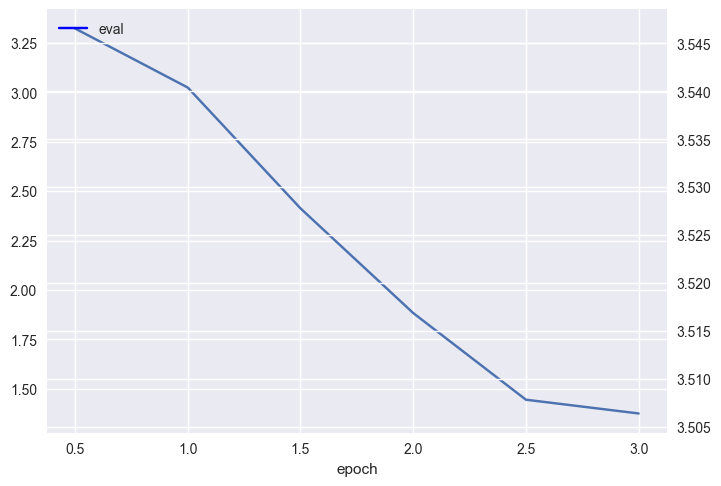

In [19]:
# example training
df_hist = data[-1]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()

In [21]:
# df_hist['learning_rate'].plot(logy=True)


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [44]:
# df_res = pd.DataFrame(data)


In [84]:
df_res = pd.DataFrame(data)
for stat in ['mean', 'std', 'min', 'max', 'sum']:
    agg = getattr(np, stat)
    df_res[f'train/before_{stat}'] = df_res['train/before'].apply(lambda x: agg(x))
    df_res[f'train/after_{stat}'] = df_res['train/after'].apply(lambda x: agg(x)) 

    # df_res[f'before_{stat}'] = df_res['before'].apply(lambda x: agg(x))
    # df_res[f'after_{stat}'] = df_res['after'].apply(lambda x: agg(x))

    # df_res[f"diff_{stat}"] = - df_res[f'before_{stat}'] + df_res[f'after_{stat}']
    # df_res[f"diff%_{stat}"] = df_res[f"diff_{stat}"] / df_res[f'before_{stat}'] * 100

    df_res[f"train/diff_{stat}"] = -df_res[f'train/before_{stat}'] + df_res[f'train/after_{stat}']
    df_res[f"train/diff%_{stat}"] = df_res[f"train/diff_{stat}"] / df_res[f'train/before_{stat}'] * 100

r = df_res.select_dtypes(include=np.number).corr()['novelty'].sort_values()
print(stat)
display(r)


sum


train/diff_sum      -0.474407
train/diff_mean     -0.383682
train/diff%_sum     -0.253703
train/diff%_mean    -0.253703
train/diff_std      -0.226926
train/diff%_std     -0.184180
train/diff_min      -0.082520
train/after_std      0.016230
train/before_max     0.026255
train/diff%_max      0.056223
train/diff_max       0.059453
train/after_mean     0.073286
train/after_max      0.082784
train/before_min     0.126469
train/after_min      0.176288
train/after_sum      0.182927
train/before_std     0.281097
train/diff%_min      0.342018
train/before_mean    0.388784
train/before_sum     0.455190
novelty              1.000000
Name: novelty, dtype: float64

In [89]:
# also try with only new stuff, no  less wrong, only less wrong...
m = df_res.url.str.contains('lesswrong').fillna(False)
r = df_res[m].select_dtypes(include=np.number).corr()['novelty'].sort_values()
print('only lesswrong')
display(r)

r = df_res[~m].select_dtypes(include=np.number).corr()['novelty'].sort_values()
print('without lesswrong')
display(r)

r = df_res[~df_res.in_training].select_dtypes(include=np.number).corr()['novelty'].sort_values()
print('only new')
display(r)

only lesswrong


/tmp/ipykernel_1883910/1966928096.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m = df_res.url.str.contains('lesswrong').fillna(False)


train/diff_sum      -0.247629
train/diff_mean     -0.159304
train/before_max    -0.077736
train/diff_std      -0.041644
train/diff%_sum     -0.034815
train/diff%_mean    -0.034815
train/before_min    -0.007299
train/after_min     -0.005681
train/diff%_std     -0.001165
train/diff_min       0.007247
train/after_std      0.111126
train/after_mean     0.168236
train/after_max      0.178731
train/before_std     0.202097
train/after_sum      0.261667
train/diff_max       0.264107
train/diff%_max      0.274232
train/diff%_min      0.318505
train/before_mean    0.390433
train/before_sum     0.418176
novelty              1.000000
Name: novelty, dtype: float64

without lesswrong


train/diff_sum      -0.524070
train/diff_mean     -0.289291
train/diff%_sum     -0.212006
train/diff%_mean    -0.212006
train/diff_std      -0.205211
train/diff%_max     -0.173305
train/diff_max      -0.153685
train/diff%_std     -0.135741
train/diff_min       0.065099
train/after_sum      0.075106
train/after_mean     0.077967
train/before_min     0.133288
train/after_std      0.148123
train/before_mean    0.209628
train/before_sum     0.217732
train/after_max      0.219580
train/before_max     0.319630
train/before_std     0.337727
train/after_min      0.384317
train/diff%_min      0.484895
novelty              1.000000
Name: novelty, dtype: float64

only new


train/diff_sum      -0.445037
train/diff_mean     -0.296686
train/diff_std      -0.175885
train/diff%_sum     -0.169818
train/diff%_mean    -0.169818
train/diff%_std     -0.149809
train/diff_min      -0.063278
train/after_std     -0.029953
train/before_max    -0.012773
train/after_mean     0.102790
train/after_max      0.116678
train/before_min     0.129897
train/diff%_max      0.131804
train/diff_max       0.133860
train/before_std     0.172009
train/after_min      0.238759
train/after_sum      0.306655
train/before_mean    0.357417
train/diff%_min      0.367850
train/before_sum     0.536616
novelty              1.000000
Name: novelty, dtype: float64

In [86]:
main_metric = 'train/diff_sum'
df_res[['f', main_metric, 'novelty', 'in_training']].sort_values( main_metric)  

,f,train/diff_sum,novelty,in_training
22,../samples/2025_lw_review-planecrash.md,-339.481621,0.933950,False
15,../samples/2025_lw_2024-in-ai-predictions.md,-297.344904,0.789190,False
23,../samples/2025_lw_the-field-of-ai-alignment-a...,-288.831029,0.925483,False
24,../samples/2025_lw_the-intelligence-curse.md,-265.925183,0.688044,False
19,../samples/2025_lw_my-agi-safety-research-2024...,-261.054373,0.756925,False
16,../samples/2025_lw_comment-on-death-and-the-go...,-239.929921,0.750253,False
21,../samples/2025_lw_preference-inversion.md,-238.890490,0.633321,False
17,../samples/2025_lw_debating-buying-nvda-in-201...,-229.822011,0.526975,False
26,../samples/2025_lw_the-subset-parity-learning-...,-224.939272,0.697946,False
8,../samples/2024_lesswrong_slop.md,-201.960423,0.100000,False


In [87]:
df_res.sort_values('train/before_sum').set_index('f').drop(columns=['content', 'hist', 'before', 'after', 'train/before', 'train/after', 'url'])

,title,novelty,date,in_training,train/before_mean,train/after_mean,train/diff_mean,train/diff%_mean,train/before_std,train/after_std,...,train/diff_min,train/diff%_min,train/before_max,train/after_max,train/diff_max,train/diff%_max,train/before_sum,train/after_sum,train/diff_sum,train/diff%_sum
f,,,,,,,,,,,,,,,,,,,,,
../samples/2024_trump_appointment.md,President Trump Announces Morgan Ortagus as De...,0.300000,2025-01-04 00:00:00+00:00,False,3.602360,1.976479,-1.625882,-45.133784,3.130189,2.116151,...,-0.005089,-82.696441,17.917255,11.689822,-6.227433,-34.756625,284.586479,156.141833,-128.444646,-45.133784
../samples/2024_how_to_focus.md,How to Focus,0.500000,2024-06-01 00:00:00+00:00,False,2.030182,1.238443,-0.791739,-38.998412,2.826893,2.380078,...,-0.000099,-40.660140,13.456800,13.169463,-0.287336,-2.135250,347.161163,211.773822,-135.387340,-38.998412
../samples/2024_gpt4_fake_paper.md,fake ai hoax paper made up by gpt-4,0.000000,2024-01-01 00:00:00+00:00,False,2.890543,1.876897,-1.013646,-35.067661,2.491279,2.017982,...,-0.000804,-71.474606,11.427372,9.812000,-1.615372,-14.135986,349.755680,227.104543,-122.651137,-35.067661
../samples/2025_h5n1_report.md,CDC Report on Missouri H5N1 Serology Testing,0.750000,2025-01-05 00:00:00+00:00,False,2.840106,1.588481,-1.251626,-44.069677,2.737036,2.004289,...,-0.002226,-77.666175,11.928956,9.404486,-2.524470,-21.162542,355.013296,198.560084,-156.453212,-44.069677
../samples/2024_arxiv_meh.md,TradingAgents: Multi-Agents LLM Financial Trad...,0.150000,2024-12-28 00:00:00+00:00,False,3.329921,2.693382,-0.636539,-19.115730,3.075030,2.940876,...,-0.000330,-61.776143,13.523319,13.253697,-0.269622,-1.993755,386.270819,312.432330,-73.838489,-19.115730
../samples/2024_lw_by-default-capital-will-matter-more-than-ever-after-agi.md,"By default, capital will matter more than ever...",0.906388,2024-12-30 19:47:19.838000+00:00,False,2.935460,1.667801,-1.267660,-43.184356,2.497172,2.004676,...,-0.007733,-65.756404,12.706497,11.517975,-1.188522,-9.353658,393.351672,223.485284,-169.866388,-43.184356
../samples/2024_news_anthropic.md,Amazon-backed Anthropic debuts AI agents that ...,0.500000,2025-01-05 05:03:00+00:00,False,2.437276,1.420116,-1.017160,-41.733471,2.880203,2.245643,...,-0.000029,-71.181132,12.790111,12.667040,-0.123071,-0.962233,424.085983,247.100184,-176.985800,-41.733471
../samples/2025_lw_the-laws-of-large-numbers.md,The Laws of Large Numbers,0.540932,2025-01-04 18:06:02.387000+00:00,False,2.887975,2.153969,-0.734006,-25.415931,2.576897,2.052082,...,-0.001162,-29.038092,11.118690,8.321499,-2.797191,-25.157557,424.532354,316.633504,-107.898850,-25.415931
../samples/politics_is_the_mind_killer.md,politics is the mind-killer,0.500000,2007-02-19 00:00:00+00:00,True,3.285058,2.430624,-0.854434,-26.009715,2.930715,2.513867,...,-0.004398,-65.298689,11.889731,11.973468,0.083736,0.704275,446.767846,330.564804,-116.203043,-26.009715


In [88]:
#  df_res.sort_values('improvement%', ascending=False)

In [ ]:
print(df_res.to_markdown())

# DEBUG

In [23]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l][-100:], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    # print(s_old, s_new)
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [24]:
sample = samples[-1]
s = sample['content']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [ ]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

In [ ]:
gen(model, ds_train.with_format('pt')[0], tokenizer)